# Building `micrograd`


This is an autodifferentiation library, which can be used to implement backpropagation

In [264]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph

%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

f(3.0)

20.0

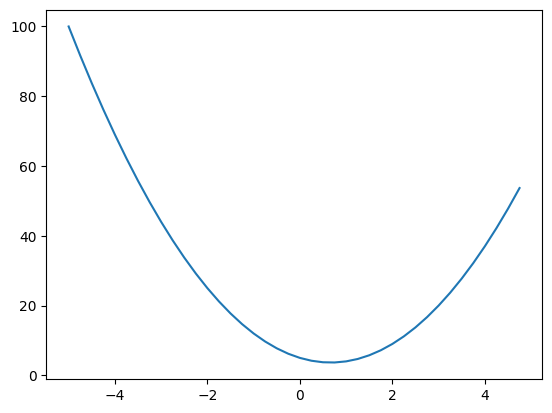

In [4]:
X = np.arange(-5, 5, 0.25)
Y = f(X)
plt.plot(X, Y)

In [5]:
# Finite difference computation of gradient at point
# (f(a + h) - f(a)) / h
a = -2.7
h = 0.0000001   # this should 

gradient = (f(a + h) - f(a)) / h
print(f"gradient at {a}: {gradient:.6f}")

gradient at -2.7: -20.200000


In [6]:
# Analytically:
# f = 3*x**2 - 4*x + 5
# df/dx = 6*x - 4
# Evaluate at x = -2.7
dfdx = 6 * (-2.7) -4.0
print(f"{dfdx=}")

# This matches the practical approach of finite differences above (floating point precision)

dfdx=-20.200000000000003


### Implementing a custom numerical type

In [331]:
class Value:
  """Data structure to represent numerical types within a neurla network.
  
  NOTE: each operation has a gradient function, and these _accumulate_ gradients, via the `+=` when adding a gradient.
        This is because we might use a value more than once, and call _backward >1 times, and we don't want to 
        override the gradient values that we already computed. Multivariate chain rule shows gradients accumulate!
  """
  
  def __init__(self, data: float, _children: tuple = (), _op="", label="?") -> None:
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None  # default function is a noop
    self._prev = set(_children)
    self._op = _op
    self.label = label
    
  def __repr__(self) -> str:
    return f"Value(data={self.data}, grad={self.grad}, label={self.label})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(data=(self.data + other.data), _children=(self, other), _op="+")
    
    # Define a backward function that will auto compute and assign gradients based on the + operation
    # It should assign gradients to both self and other
    def backward_fn():
      """Implement auto-grad for the `+` operation on two inputs: self and other."""
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    # Store closure fn on object for use later.
    out._backward = backward_fn

    return out
  
  def __rmul__(self, other):
    """Call when python fails to call `__mul__` on `a * b` -> looks to see if rmul is defined on `b`."""
    # We just swap the order of the operands.
    return self * other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(data=float(other))
    mul_result = self.data * other.data
    out = Value(data=mul_result, _children=(self, other), _op="*")
    
    def backward_fn():
      """Implement auto-grad for the `*` operation on two inputs: self and other."""
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
      
    # Store closer fn on object.
    out._backward = backward_fn
    
    return out
  
  def __radd__(self, other):
    return self + other

  def __truediv__(self, other) -> "Value":
    return self * other**-1
  
  def __sub__(self, other):
    return self + (-other)  # self - other
  
  def __rsub__(self, other):
    return -other + self
  
  def __neg__(self):
    return self * -1

  def __pow__(self, k) -> "Value":
    """Raise the data to the k'th power"""
    if not isinstance(k, (int, float)):
      raise ValueError(f"Value's `exp` method can only accept integers and float; received: {type(k)=}")

    out = Value(self.data**k, _children=(self,), _op=f"**{k}")
    
    def backward_fn():
      # a ** k  ->   (k) * a**(k-1)
      # a 
      local = k * self.data**(k-1)
      self.grad += out.grad * local
      
    out._backward = backward_fn
    
    return out
  
  def exp(self):
    """Exponentiate the data in self."""
    data = self.data
    raw_out = math.exp(data)
    out = Value(data=raw_out, _children=(self,), _op="exp")
    
    def backward_fn():
      """Implement auto-grad for `exp` on the input: self."""
      self.grad += out.grad * out.data  # out.data is just the result of math.exp(self.data) - the local derivative
      
    out._backward = backward_fn

    return out

  def tanh(self):
    # Cheating: out = Value(math.tanh(self.data), _children=(self,), _op="tanh")
    # tanh = (e^2x - 1) / (e^2x + 1)
    out_raw = (math.exp(2 * self.data) - 1.0) / (math.exp(2 * self.data) + 1.0)
    out = Value(out_raw, _children=(self,), _op="tanh")
    
    def backward_fn():
      """Implement auto-grad for `tanh` on the input: self."""
      self.grad += out.grad * (1 - out_raw**2)
      
    out._backward = backward_fn

    return out
  
  def backward(self):
    """Execute ._backward for each noe, but only after it has been called on all its own children.
    
    Computes the topologically sorted list of nodes, recursively backward from v to all children.
    """
    visited = set()
    topo = []
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    
    # We should only call backward ont eh output node itself, where the base case gradient equals zero
    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

### Viz code

In [80]:
def trace(root: Value) -> tuple[set, set]:
  """Build a set of all nodes and adges in a graph, given the root node."""
  nodes, edges = set(), set()
  
  def build(v: Value):
    """Populate the nodes and edges by iterating over the graph, starting at the root."""
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # for any value int he graph, create a rectangular ("record") node for it
    dot.node(name=uid, label=f"{{{n.label} | data: {n.data:.2f}}} | grad: {n.grad:.4f}", shape="record")
    if n._op:
      op_uid = uid + n._op
      # If this value is the result of some operation, create a node to represent the op
      dot.node(name=op_uid, label=n._op)
      # ... and connect this node to it
      dot.edge(op_uid, uid)
      
  for n1, n2, in edges:
    # Connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
  return dot

In [103]:
# Obviously dL/dL is one -> if we change L by h, the change is h -> normalising by h gives 1.
L.grad = 1.0

# Compute gradient of d
# Given: L = d * f
dLdd = f
dLdf = d

d.grad = f.data
f.grad = d.data

# Go further - derive dL/dc
# d = c + e
dddc = 1.0
ddde = 1.0
# dL/dc = dL/dd * dd/dc
#  -> dd/dc is the local gradient (node we're coming from to the node we care about)
#  -> We apply the chain rule here using the local gradient with the parent gradient
#  -> Partial gradient of C = partial gradient of D, times one 
#  -> backprop through an addition just replicates the gradients back, simply copying/routing them
c.grad = d.grad * dddc
# By symmetry, the same applies to e
e.grad = d.grad * ddde

# Backprop from e into a and b
# e = a * b
deda = b.data
dedb = a.data
# For a: dL/da = dL/de * de/da
a.grad = e.grad * deda
# For b: dL/db = dL/de * de/db
b.grad = e.grad * dedb

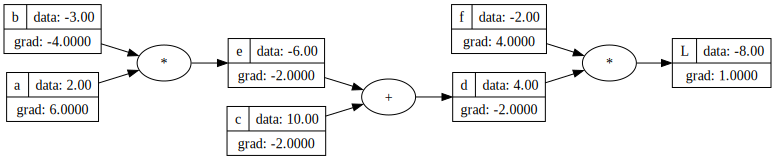

In [104]:
draw_dot(L)

In [239]:
# Example of single neuron
# Inputs: x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights: w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias of the neuron: b
b = Value(6.8813735870195432, label="b")

# Replicate the process of a neuron: sum(inputs*weights) + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"

# Now apply activation function: tanh
o = n.tanh(); o.label = "o"

o.backward()

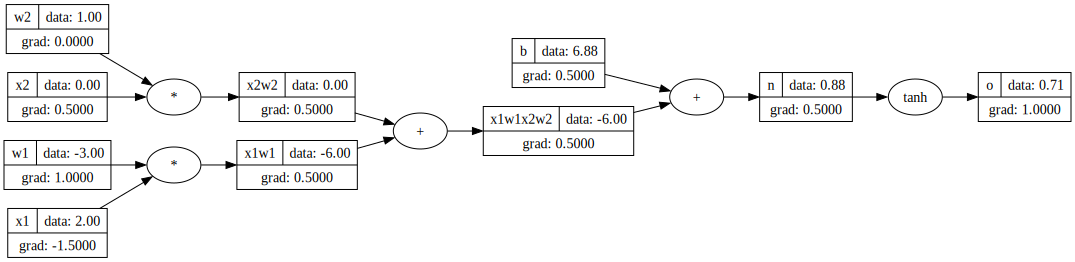

In [240]:
draw_dot(o)

In [254]:
# Example of single neuron
# Inputs: x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights: w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias of the neuron: b
b = Value(6.8813735870195432, label="b")

# Replicate the process of a neuron: sum(inputs*weights) + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"

# Now apply activation function: tanh
#o = n.tanh(); o.label = "o"

# Manually compute tanh using the more basic ops
# tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
e = (2 * n).exp(); e.label= "e"
o = (e - 1) / (e + 1); o.label = "o"

o.backward()

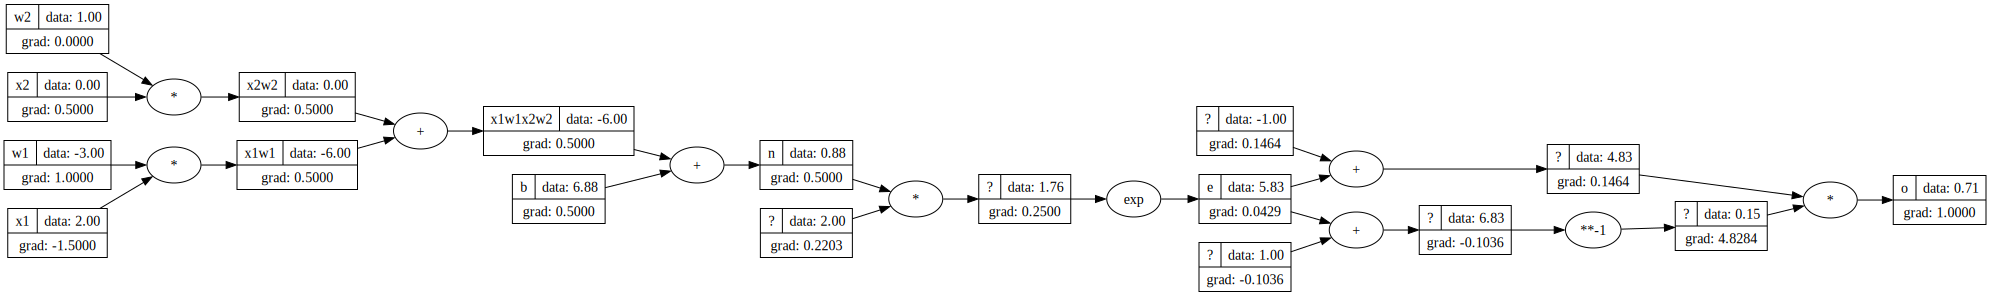

In [255]:
draw_dot(o)

## Same graph, but via `torch`

In [263]:
import torch

x1 = torch.Tensor([2]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();  b.requires_grad = True
n = x1*w1 + x2*w2 + b;                            #  n.requires_grad = True   -> not required as children have it
o = torch.tanh(n)

print(o.item())
o.backward()

print("----------")
print(f"{w2.grad=}")
print(f"{x2.grad=}")
print(f"{w1.grad=}")
print(f"{x1.grad=}")

# This matches our manual version above

0.7071066904050358
----------
w2.grad=tensor([0.], dtype=torch.float64)
x2.grad=tensor([0.5000], dtype=torch.float64)
w1.grad=tensor([1.0000], dtype=torch.float64)
x1.grad=tensor([-1.5000], dtype=torch.float64)


## Implement a single `Neuron`

In [348]:
sum((l for l in [[1, 2], [3], [4, 5, 6]]), start=[])

[1, 2, 3, 4, 5, 6]

In [353]:
class Neuron:
  
  def __init__(self, n_in: int) -> None:
    self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1, 1))
    
  def __call__(self, x):
    """Perform the execution of inputs against the weights of this Neuron. Execution means dot product."""
    dotprod = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
    out = dotprod.tanh()  # apply non-linearity
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in=n_in) for _ in range(n_out)]
    
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return sum((n.parameters() for n in self.neurons), start=[])


class MLP:
  
  def __init__(self, n_in, n_outs):
    """Stack multiple layers.
    
    Args:
      n_in: the size of the input data, so how many input neurons we need.
      n_outs: a list of the output sizes for each layer -> implicity gives desired number of layers.
    """
    sizes = [n_in] + n_outs
    self.layers = [Layer(n_in=sizes[i], n_out=sizes[i+1]) for i in range(len(n_outs))]
    
  def __call__(self, x):
    # call each layer on the inputs, which are overwritten in place on each call
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return sum((l.parameters() for l in self.layers), start=[])


In [354]:
x = [2.0, 3.0, -1.0]  # input data

# n = Neuron(n_inputs=2)
# n(x)

# L = Layer(n_in=2, n_out=5)
# L(x)

mlp = MLP(n_in=3, n_outs=[4, 4, 1])
mlp(x)

Value(data=-0.5910787242716327, grad=0.0, label=?)

In [355]:
len(mlp.parameters())

41

In [431]:
# Example input data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# Targets for binary classification
ys = [1.0, -1.0, -1.0, 1.0]

# Define the model
mlp = MLP(n_in=3, n_outs=[3, 5, 1])

In [359]:
mlp.layers[0].neurons[0].w[0]  # we now have a gradient for this single weight (and all others)
# We now know in which direction to nudge the weight to move the output in the right direction!

Value(data=0.04273703353398983, grad=-0.04406248388198129, label=?)

In [369]:
mlp.layers[0].neurons[0].w[0]  # we now have a gradient for this single weight (and all others)
# We now know in which direction to nudge the weight to move the output in the right direction!

Value(data=0.21672099702703126, grad=-0.7776408963728503, label=?)

In [492]:
n_epochs = 100
lr = 0.1

for k in range(100):

  # Forward pass
  preds = [mlp(x) for x in xs]
  # Evaluate the loss
  loss = sum((y_true - y_pred)**2 for y_true, y_pred in zip(ys, preds))
  
  if k % 10 == 0:
    print(f"{k:>2}  {loss.data=}")

  for p in mlp.parameters():
    p.grad = 0.0

  # Backward pass
  loss.backward()

  for p in mlp.parameters():
    p.data += -lr * p.grad

 0  loss.data=5.212728762069343e-05
10  loss.data=5.195112447826117e-05
20  loss.data=5.1776118641034876e-05
30  loss.data=5.160225886008707e-05
40  loss.data=5.142953403095574e-05
50  loss.data=5.125793319133413e-05
60  loss.data=5.1087445518812015e-05
70  loss.data=5.091806032865889e-05
80  loss.data=5.0749767071657845e-05
90  loss.data=5.058255533195847e-05


In [493]:
preds

[Value(data=0.9978610031074776, grad=-0.004277993785044787, label=?),
 Value(data=-0.997388458464833, grad=0.005223083070333923, label=?),
 Value(data=-0.9954922442399273, grad=0.009015511520145347, label=?),
 Value(data=0.9956736086547724, grad=-0.008652782690455219, label=?)]

In [494]:
print("GT    ->  Final preds:")
for y, yhat in zip(ys, preds):
  print(f"{y:>5.2f} -> {yhat.data:>10.7f}")

GT    ->  Final preds:
 1.00 ->  0.9978610
-1.00 -> -0.9973885
-1.00 -> -0.9954922
 1.00 ->  0.9956736


In [419]:
# Implement MSE to measure the loss
loss = sum((y_true - y_pred)**2 for y_true, y_pred in zip(ys, preds))
loss

Value(data=4.9160968226745304e-05, grad=0.0, label=?)

In [420]:
loss.backward()

In [421]:
# Go over all weights and slightly update their weights based on the gradient information
lr = 0.001
for p in mlp.parameters():
  p.data += -lr * p.grad  # The gradient shows the sensitivity of the output to this parameter
  # a negative gradient (-0.04406 above) means a lower value would increase the loss
  # a positive gradient would mean that a lower value would decrease the loss
  # We want to decrease the loss, therefore we flip the sign on the gradient before applying the update

Run backprop via our backward functions, ensuring to execute in the correct order.

Afterwards, we must implement the iteration such that we can perform this same cascade in one call.

In [162]:
o._backward()

In [163]:
n._backward()  # route gradients through the + op

In [164]:
b._backward()  # has no effect, as b is a leaf node, and the backward function is therefore a noop

In [165]:
x1w1x2w2._backward()  # routes gradients again, as the nodes op is a +

In [166]:
x1w1._backward()
x2w2._backward()

In [168]:
# Calling _backward on the remaining leaf nodes does nothing
x1._backward()
w1._backward()
x2._backward()
w2._backward()

As well as calling _backward() on all the nodes in the correct order, we must also only call backward on a node after it has already been called on all the previous nodes; all of its dependencies.

We can perform a topological sort in order to map out these dependendencies and give ourselves an order to call _backward() on the nodes.

## Test code

$$tanh(x) = \frac{e^{2x} -1}{e^{2x} + 1}$$

$$\frac{dtanh}{dx} = \frac{u}{v}$$

$$tanh(x) = \frac{u}{v}$$

where;

$$u = e^{2x} -1$$

$$v = (e^{2x} + 1)^{-1}$$

Meaning,

$$\frac{du}{dx} = 2e^{2x}$$

$$\frac{dv}{dx} = -1 * 2e^{2x} * (e^{2x} + 1)^{-2}$$

$$\frac{dv}{dx} = -2e^{2x} * (e^{2x} + 1)^{-2}$$

Applying the chain rule for derivatives:

$$\frac{dtanh}{dx} = v \cdot \frac{du}{dx} - u \cdot \frac{dv}{dx}$$

Multiply out:

$$ ((e^{2x} + 1)^{-1} \cdot 2e^{2x}) - ((e^{2x} -1) \cdot (-2e^{2x} \cdot (e^{2x} + 1)^{-2}) $$

Simplify:

...

Result:

$$\frac{dtanh(x)}{dx} = 1 - tanh(x)^2$$

In [ ]:

draw_dot()

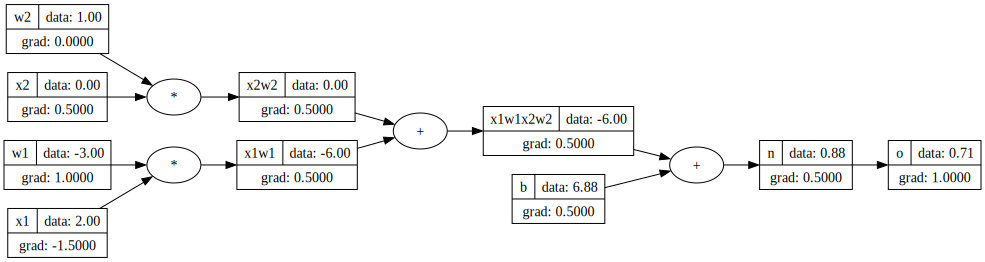

In [133]:
# Perform backprop - compute the gradients

# Derivative of the output is always just 1.0
o.grad = 1.0

# Backprop through tanh
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# We know already tanh(n) just gives o:
dodn = 1 - o.data**2
n.grad = dodn

# Backprop into x1w1x2w2 and our bias
# n = x1w1x2w2 + b
dndX = 1.0  # X short for x1w1x2w2
dndb = 1.0
# do/dX = do/dn * dndX
dodX = n.grad * dndX
x1w1x2w2.grad = dodX
# do/dX = do/dn * dndb
dodb = n.grad * dndb
b.grad = dodb

# Going through another + op, so simply replicate gradients backwards to input nodes of x1w1x2w2
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# Back through multiplication of inputs and weights
# x1w1 = x1 * w1
dx1w1_dw1 = x1.data
# do/dw1 = do/dx1w1 * dx1w1/dw1
do_dw1 = x1w1.grad * dx1w1_dw1
w1.grad = do_dw1

# do/dx1 = do/dx1w1 * dx1w1/dx1
dx1w1_dx1 = w1.data
do_dx1 = x1w1.grad * dx1w1_dx1
x1.grad = do_dx1

# x2w2 = x2 * w2
# do/dx2 = do/dx2w2 * dx2w2/dx2
dx2w2_dx2 = w2.data
do_dx2 = x2w2.grad * dx2w2_dx2
x2.grad = do_dx2

# do/dw2 = do/dx2w2 * dx2w2/dw2
dx2w2_dw2 = x2.data
do_dw2 = x2w2.grad * dx2w2_dw2
w2.grad = do_dw2

In [131]:
def lol():
  """Perform manual gradient check - verify the change in the output due to a delta-change in a node."""
  h = 0.000001

  # Inputs: x1, x2
  x1 = Value(2.0, label="x1")
  x2 = Value(0.0, label="x1")
  # Weights: w1, w2
  w1 = Value(-3.0, label="w1") 
  w2 = Value(1.0, label="w2")
  # Bias of the neuron: b
  b = Value(6.8813735870195432, label="b")

  # Replicate the process of a neuron: sum(inputs*weights) + b
  x1w1 = x1 * w1; x1w1.label = "x1w1"
  x2w2 = x2 * w2; x2w2.label = "x2w2"
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
  n = x1w1x2w2 + b; n.label = "n"

  # Now apply activation function
  o = n.tanh(); o.label = "o"
  L1 = o.data
  
  # Make a change
  w1.data += h

  x1 = Value(2.0, label="x1")
  x2 = Value(0.0, label="x1")
  # Weights: w1, w2
  w1 = Value(-3.0, label="w1")
  w2 = Value(1.0, label="w2")
  # Bias of the neuron: b
  b = Value(6.8813735870195432, label="b")

  # Replicate the process of a neuron: sum(inputs*weights) + b
  x1w1 = x1 * w1; x1w1.label = "x1w1"
  x2w2 = x2 * w2; x2w2.label = "x2w2"
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
  n = x1w1x2w2 + b; n.label = "n"

  # Now apply activation function
  o = n.tanh(); o.label = "o"
  L2 = o.data

  grad = (L2 - L1) / h
  print(grad)
  
lol()

0.0
